# Evaluation Snorkel: Extration de partenariats d'entreprises
# Partie II: Génération et modélisation des labels d'entrainements
---

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re

import numpy as np
from snorkel import SnorkelSession
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels
from snorkel.viewer import SentenceNgramViewer
from snorkel.lf_helpers import test_LF
from snorkel.annotations import load_gold_labels
from snorkel.annotations import LabelAnnotator
from snorkel.learning import GenerativeModel
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
    rule_regex_search_before_A
)
from lib.scoring import *

session = SnorkelSession()

On initialise notre relation de partenariat entre 2 entreprises

In [2]:
Partner = candidate_subclass('Partner', ['company1', 'company2'])

# 1. Préparation

## 1.2 Chargement de notre jeu de données de _development_

Nous chargeons les données qui ont été labelisées manuellement et qui font parties de notre jeu de développement (split = 1)

In [3]:
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

In [4]:
L_gold_dev.shape

(351, 1)

### Data exploration

Voyons les données pour nous aider à créer les fonctions de labeling.

In [23]:
# load our list of training & development candidates
train_cands = session.query(Partner).filter(Partner.split == 0).all()
dev_cands   = session.query(Partner).filter(Partner.split == 1).all()

SentenceNgramViewer(dev_cands, session, n_per_page=1)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[296]], [[253]], [[29, 30, 31, 146, 147, 301]], [[255, 256, 257, 258, 277, 278, 279…

# 2. Ecriture des Labeling Functions

### Métriques de nos Labeling Function

####  Coverage
C'est le nombre de candidats labelisés par notre LF sur un jeu de données (entrainement).

####  Precision / Recall / F1
Métriques standard pour les classification : précision, rappel, F1-score

### Pattern-based LFs

In [6]:
# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'

#### Detection des partenariats

In [7]:
def LF_partners_btw(c):
    partnership = ['partner[sd]?', 'partnering', 'partnership with']
    return 1 if re.search(r'{{A}}.{0,50} ' + ltp(partnership) + '.{0,50}{{B}}', get_tagged_text(c), re.I) else 0

In [8]:
# what candidates are covered by this LF?
labeled = coverage(session, LF_partners_btw, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)

Coverage: 2.63% (102/3871)


<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[29, 48, 72]], [[0]], [[82, 83]], [[80, 81]], [[23, 49]], [[34]], [[37, 38]], [[35,…

In [9]:
tp, fp, tn, fn = error_analysis(session, LF_partners_btw, split=1, gold=L_gold_dev)
# now let's view what this LF labeled
SentenceNgramViewer(tp, session, n_per_page=1)

LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.9
Recall               1.0
F1                   0.947
----------------------------------------
TP: 9 | FP: 1 | TN: 0 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[8]], [[0, 1]], [[5]], [[4]], [[7]], [[6]], [[2, 3]]], html='<head>\n<style>\nspan.…

In [10]:
def LF_partners_before(c):
    partnership = ['partner[s]?', 'partnership']
    return rule_regex_search_before_A(c, ltp(partnership) + '.{0,50}', 1)

labeled = coverage(session, LF_partners_before, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)

Coverage: 5.22% (202/3871)


<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[128]], [[125]], [[14, 15]], [[148, 149, 168]], [[146, 147, 167]], [[158]], [[13]],…

In [11]:
labeled = coverage(session, LF_partners_before, split=1)
SentenceNgramViewer(labeled, session, n_per_page=1)

Coverage: 10.26% (36/351)


<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[8]], [[18]], [[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 21, 22, 23, 24, 25, 26,…

In [12]:
tp, fp, tn, fn = error_analysis(session, LF_partners_before, split=1, gold=L_gold_dev)
# now let's view what this LF labeled
SentenceNgramViewer(fp, session, n_per_page=1)

LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 19 | FP: 0 | TN: 0 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\n…

In [13]:
def LF_partners_after(c) :
    partners = {'partnership', 'partners', 'partner'}
    return 1 if len(partners.intersection(get_right_tokens(c[1], window=15))) > 0 else 0

labeled = coverage(session, LF_partners_after, split=1)
SentenceNgramViewer(labeled, session, n_per_page=1)

Coverage: 5.13% (18/351)


<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[14]], [[0]], [[1]], [[7]], [[3, 4, 5, 6, 11, 12, 15, 16, 17]], [[8, 9, 10]], [[13]…

In [14]:
tp, fp, tn, fn = error_analysis(session, LF_partners_after, split=1, gold=L_gold_dev)
# now let's view what this LF labeled
SentenceNgramViewer(tp, session, n_per_page=1)

LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 10 | FP: 0 | TN: 0 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[7]], [[0]], [[1]], [[5]], [[3, 4, 6, 8, 9]], [[2]]], html='<head>\n<style>\nspan.c…

#### Collaboration

In [15]:
def LF_collaboration_btw(c):
    collaboration = ['collaborate[sd]?', 'collaborating', 'collaboration', 'association', 'associate[sd]?']
    return 1 if re.search(r'{{A}}.{0,50} ' + ltp(collaboration) + '.{0,50}{{B}}', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_collaboration_btw, split=0)

Coverage: 0.57% (22/3871)


In [16]:
tp, fp, tn, fn = error_analysis(session, LF_collaboration_btw, split=1, gold=L_gold_dev)
SentenceNgramViewer(tp, session, n_per_page=1)

LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 3 | FP: 0 | TN: 0 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[0, 2]], [[1]]], html='<head>\n<style>\nspan.candidate {\n    background-color: rgb…

In [17]:
def LF_alliances(c) :
    alliances = {'alliance', 'alliances', 'jointly'}
    if len(alliances.intersection(get_left_tokens(c[0], window=12))) > 0 :
        return 1
    elif len(alliances.intersection(get_right_tokens(c[1], window=12))) > 0 :
        return 1
    else :
        return 0

labeled = coverage(session, LF_alliances, split=0)

Coverage: 3.10% (120/3871)


In [18]:
tp, fp, tn, fn = error_analysis(session, LF_alliances, split=1, gold=L_gold_dev)

LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 3 | FP: 0 | TN: 0 | FN: 0



## Les non-partenariats

In [39]:
partners = {'partnership', 'partnerships','Partnering', 'partnered', \
            'partners', 'partner', 'collaborates', 'collaboration', 'jointly', 'collaborated',\
            'join', 'joined'
           }
def LF_no_partner_in_sentence(c):
    return -1 if np.random.rand() < 0.75 and len(partners.intersection(c.get_parent().words)) == 0 else 0

labeled = coverage(session, LF_no_partner_in_sentence, split=0)
tp, fp, tn, fn = error_analysis(session, LF_no_partner_in_sentence, split=1, gold=L_gold_dev)

SentenceNgramViewer(fn, session, n_per_page=1)

Coverage: 61.33% (2374/3871)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 32 | FN: 20



<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[13]], [[4, 5]], [[3]], [[19]], [[7]], [[18]], [[17]], [[2]], [[12]], [[16]], [[0, …

In [40]:
competitors = ['competitor[s]?', 'competitive', 'competition', 'vs', 'rival[s]', 'versus','alternative[s]?']
def LF_competitor(c) :
    return -1 if re.search(r'{{A}}.{0,50} ' + ltp(competitors) + '.{0,50}{{B}}', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_competitor, split=0)
tp, fp, tn, fn = error_analysis(session, LF_competitor, split=1, gold=L_gold_dev)

Coverage: 0.80% (31/3871)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 0.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 0 | FN: 0



In [41]:
def LG_competitors_before_after(c) :
    comp = {'competitors', 'competition', 'competitor'}
    if len(comp.intersection(get_left_tokens(c[0], window=12))) > 0 :
        return -1
    elif len(comp.intersection(get_right_tokens(c[1], window=12))) > 0 :
        return -1
    else :
        return 0

labeled = coverage(session, LG_competitors_before_after, split=0)
tp, fp, tn, fn = error_analysis(session, LG_competitors_before_after, split=1, gold=L_gold_dev)

Coverage: 0.85% (33/3871)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 0.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 0 | FN: 0



In [42]:
def LG_acquisitions(c) :
    acquisitions = {'acquire', 'acquires',  'acquisition', 'acquired'}
    if len(acquisitions.intersection(get_left_tokens(c[0], window=10))) > 0 :
        return -1
    elif len(acquisitions.intersection(get_right_tokens(c[1], window=10))) > 0 :
        return -1
    elif len(acquisitions.intersection(get_between_tokens(c))) > 0 :
        return -1
    else :
        return 0
    
labeled = coverage(session, LG_acquisitions, split=0)
tp, fp, tn, fn = error_analysis(session, LG_acquisitions, split=1, gold=L_gold_dev)

Coverage: 1.73% (67/3871)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 1 | FN: 0



In [43]:
# same company name
def LG_sameNames(c) :
    c1_name = c.company1.get_span()
    c2_name = c.company2.get_span()
    if c1_name == c2_name:
        return -1
    return 0

labeled = coverage(session, LG_sameNames, split=0)
tp, fp, tn, fn = error_analysis(session, LG_sameNames, split=1, gold=L_gold_dev)

Coverage: 11.34% (439/3871)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 0.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 0 | FN: 0



On regroupe toutes les fonctions dans une liste.

In [44]:
LFs = [
    LF_partners_btw, LF_partners_before, 
    LF_partners_after, LF_collaboration_btw, LF_alliances,
    LF_no_partner_in_sentence,
    #LF_competitor, LG_competitors_before_after,
    LG_acquisitions#, LG_sameNames
]

## 2. Applying the Labeling Functions

Next, we need to actually run the LFs over all of our training candidates, producing a set of `Labels` and `LabelKeys` (just the names of the LFs) in the database.  We'll do this using the `LabelAnnotator` class, a UDF which we will again run with `UDFRunner`.  **Note that this will delete any existing `Labels` and `LabelKeys` for this candidate set.**  We start by setting up the class:

In [45]:
labeler = LabelAnnotator(lfs=LFs)

In [46]:
np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 22.1 s, sys: 445 ms, total: 22.5 s
Wall time: 23.3 s


<3871x7 sparse matrix of type '<class 'numpy.int64'>'
	with 3102 stored elements in Compressed Sparse Row format>

In [47]:
%time L_train = labeler.load_matrix(session, split=0)
L_train

CPU times: user 45.2 ms, sys: 7.28 ms, total: 52.5 ms
Wall time: 60.1 ms


<3871x7 sparse matrix of type '<class 'numpy.int64'>'
	with 3102 stored elements in Compressed Sparse Row format>

In [48]:
L_train.get_candidate(session, 30)

Partner(Span("b'Century Link'", sentence=1299, chars=[56,67], words=[9,10]), Span("b'Virtustream'", sentence=1299, chars=[140,150], words=[25,25]))

In [49]:
L_train.get_key(session, 0)

LabelKey (LF_partners_btw)

In [50]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_partners_btw,0,0.026350,0.009817,0.004133
LF_partners_before,1,0.052183,0.025575,0.013950
LF_partners_after,2,0.041333,0.015500,0.007233
LF_collaboration_btw,3,0.005683,0.000775,0.000517
LF_alliances,4,0.031000,0.021700,0.019117
LF_no_partner_in_sentence,5,0.627486,0.048825,0.035908
LG_acquisitions,6,0.017308,0.013175,0.000258


## 3. Fitting the Generative Model
Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [51]:
gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [52]:
gen_model.weights.lf_accuracy

array([ 0.07852471,  0.07888784,  0.08908495,  0.07626741,  0.06603242,
        0.6859013 ,  0.08876662])

In [53]:
train_marginals = gen_model.marginals(L_train)

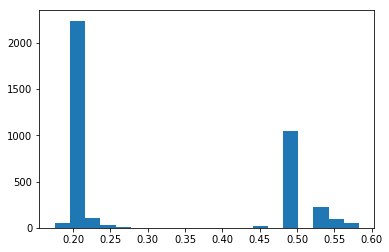

In [54]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [55]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.533075,0.6697,0.534905,0.351400
1,0.538805,0.6726,0.548843,0.362517
2,0.544285,0.6684,0.545053,0.367481
3,0.531231,0.6628,0.537736,0.350804
4,0.528228,0.6660,0.532936,0.354973
5,0.802175,0.7173,0.801667,0.572960
6,0.543793,0.6622,0.547858,0.357951


### Using the Model to Iterate on Labeling Functions

Now that we have learned the generative model, we can stop here and use this to potentially debug and/or improve our labeling function set.  First, we apply the LFs to our development set:

In [56]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [57]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.487
Neg. class accuracy: 0.898
Precision            0.569
Recall               0.487
F1                   0.525
----------------------------------------
TP: 37 | FP: 28 | TN: 247 | FN: 39



### Doing Some Error Analysis

In [58]:
sv = SentenceNgramViewer(tp, session,  n_per_page=1)

<IPython.core.display.Javascript object>

In [59]:
sv

SentenceNgramViewer(cids=[[[31]], [[5, 32]], [[9]], [[8]], [[0, 1]], [[11]], [[3]], [[7]], [[6, 22]], [[20]], …

In [60]:
c = sv.get_selected() if sv else list(fp.union(fn))[0]
c

Partner(Span("b'Dell'", sentence=721, chars=[162,165], words=[28,28]), Span("b'Nutanix'", sentence=721, chars=[193,199], words=[33,33]))

In [61]:
c.id

4043

In [62]:
c.labels

[Label (LF_partners_btw = 1), Label (LF_partners_after = 1)]

In [63]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_partners_btw,0,0.045584,0.002849,0.000000,9,1,0,0,0.900000,0.540433
LF_partners_before,1,0.102564,0.025641,0.000000,19,0,0,0,1.000000,0.537639
LF_partners_after,2,0.051282,0.028490,0.000000,10,0,0,0,1.000000,0.553351
LF_collaboration_btw,3,0.008547,0.000000,0.000000,3,0,0,0,1.000000,0.533136
LF_alliances,4,0.011396,0.005698,0.005698,3,0,0,0,1.000000,0.525523
LF_no_partner_in_sentence,5,0.595442,0.005698,0.005698,0,0,25,34,0.576271,0.795723
LG_acquisitions,6,0.002849,0.000000,0.000000,0,0,0,1,1.000000,0.543601
